# **INTRODUCTION**

# **IMPORTING THE LIBRARIES**

In [121]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as py
import statsmodels.api as sm
from statsmodels.formula.api import ols
import mpl_scatter_density # adds projection='scatter_density'
from matplotlib.colors import LinearSegmentedColormap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

# **EXPLORING THE DATA**

In [122]:
data = pd.read_csv("SalesKaggle3.csv")
data.head(10)

,Order,File_Type,SKU_number,SoldFlag,SoldCount,MarketingType,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
0,2,Historical,1737127,0.0,0.0,D,15,1,682743.0,44.99,2015,8,28.97,31.84
1,3,Historical,3255963,0.0,0.0,D,7,1,1016014.0,24.81,2005,39,0.00,15.54
2,4,Historical,612701,0.0,0.0,D,0,0,340464.0,46.00,2013,34,30.19,27.97
3,6,Historical,115883,1.0,1.0,D,4,1,334011.0,100.00,2006,20,133.93,83.15
4,7,Historical,863939,1.0,1.0,D,2,1,1287938.0,121.95,2010,28,4.00,23.99
5,8,Historical,214948,0.0,0.0,D,0,0,1783153.0,132.00,2011,33,138.98,13.64
6,9,Historical,484059,0.0,0.0,D,13,1,2314801.0,95.95,2010,33,90.77,46.49
7,10,Historical,146401,0.0,0.0,D,4,1,721111.0,207.80,2011,57,187.90,30.56
8,11,Historical,110568,0.0,0.0,D,11,1,436667.0,119.81,2008,36,63.99,96.92
9,12,Historical,764270,0.0,0.0,D,5,1,6652211.0,49.95,2004,19,53.99,28.99


In [123]:
data.shape

(198917, 14)

In [124]:
data.dtypes

Order                 int64
File_Type            object
SKU_number            int64
SoldFlag            float64
SoldCount           float64
MarketingType        object
ReleaseNumber         int64
New_Release_Flag      int64
StrengthFactor      float64
PriceReg            float64
ReleaseYear           int64
ItemCount             int64
LowUserPrice        float64
LowNetPrice         float64
dtype: object

In [125]:
data.nunique()

Order               198917
File_Type                2
SKU_number          133360
SoldFlag                 2
SoldCount               37
MarketingType            2
ReleaseNumber           71
New_Release_Flag         2
StrengthFactor      197424
PriceReg             11627
ReleaseYear             85
ItemCount              501
LowUserPrice         12102
LowNetPrice          15403
dtype: int64

Xóa Order

In [126]:
data.drop(['Order'], inplace = True, axis = 1)

In [127]:
data.isnull().sum()

File_Type                0
SKU_number               0
SoldFlag            122921
SoldCount           122921
MarketingType            0
ReleaseNumber            0
New_Release_Flag         0
StrengthFactor           0
PriceReg                 0
ReleaseYear              0
ItemCount                0
LowUserPrice             0
LowNetPrice              0
dtype: int64

In [128]:
display(data.isnull().sum()/len(data))

File_Type           0.000000
SKU_number          0.000000
SoldFlag            0.617951
SoldCount           0.617951
MarketingType       0.000000
ReleaseNumber       0.000000
New_Release_Flag    0.000000
StrengthFactor      0.000000
PriceReg            0.000000
ReleaseYear         0.000000
ItemCount           0.000000
LowUserPrice        0.000000
LowNetPrice         0.000000
dtype: float64

Hai cột NULL khi File_Type là 'Active'

In [129]:
data.fillna(0, inplace = True)

In [130]:
data.describe(percentiles = [.1, .25, .5, .75, .995])

,SKU_number,SoldFlag,SoldCount,ReleaseNumber,New_Release_Flag,StrengthFactor,PriceReg,ReleaseYear,ItemCount,LowUserPrice,LowNetPrice
count,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,1.989170e+05,198917.000000,198917.000000,198917.000000,198917.000000,198917.000000
mean,8.613626e+05,0.065334,0.123137,3.412202,0.642248,1.117115e+06,90.895243,2006.016414,41.426283,30.982487,46.832053
std,8.699794e+05,0.247115,0.739101,3.864243,0.479340,1.522090e+06,86.736367,9.158331,37.541215,69.066155,128.513236
min,5.000100e+04,0.000000,0.000000,0.000000,0.000000,6.275000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
10%,1.140020e+05,0.000000,0.000000,0.000000,0.000000,5.201720e+04,25.000000,1998.000000,15.000000,4.000000,9.500000
25%,2.172520e+05,0.000000,0.000000,1.000000,0.000000,1.614188e+05,42.000000,2003.000000,21.000000,4.910000,17.950000
50%,6.122080e+05,0.000000,0.000000,2.000000,1.000000,5.822240e+05,69.950000,2007.000000,32.000000,16.080000,33.980000
75%,9.047510e+05,0.000000,0.000000,5.000000,1.000000,1.430083e+06,116.000000,2011.000000,50.000000,40.240000,55.490000
99.5%,3.802163e+06,1.000000,4.000000,20.000000,1.000000,8.959059e+06,392.950000,2015.000000,222.000000,194.453000,308.044600
max,3.960788e+06,1.000000,73.000000,99.000000,1.000000,1.738445e+07,12671.480000,2018.000000,2542.000000,14140.210000,19138.790000


In [131]:
data = data[data['SoldCount'] <= 10]
data = data[data['ReleaseYear'] >= 1900]
data = data[data['ReleaseNumber'] <= 20]
data = data[data['PriceReg'] <= 1000]
data = data[data['ItemCount'] <= 500]
data = data[data['LowUserPrice'] <= 500]
data = data[data['LowNetPrice'] <= 500]

Drop outliers

In [132]:
data['ReleaseYear'] = 2022 - data['ReleaseYear']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# **VISUALIZATION**

In [133]:
numeric = data.select_dtypes(exclude=object).columns
category = data.select_dtypes(include=object).columns

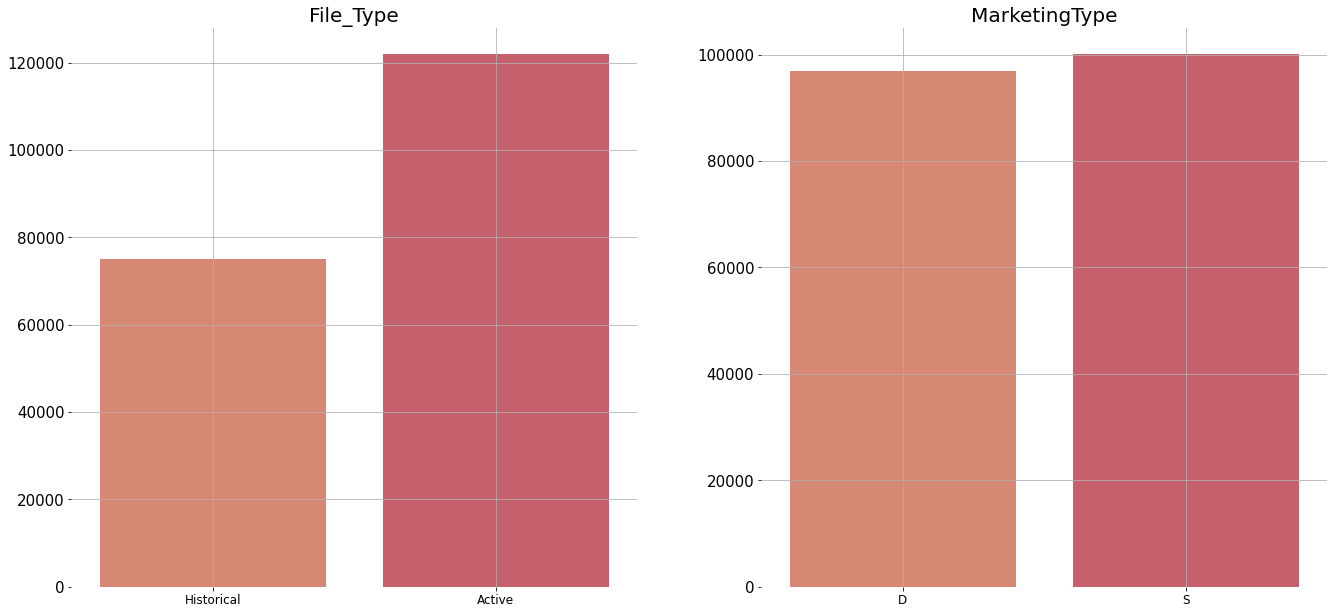

In [134]:
fig, ax = plt.subplots(figsize =(20, 10))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("flare", n_colors = 4).as_hex()
for i in (enumerate(category)):
  plt.subplot(1, 2, i[0]+1)
  sns.countplot(x = i[1], data = data, palette = colors, fill=True)
  plt.xlabel('')
  plt.ylabel('')
  plt.yticks(fontsize = 15, color='black')
  plt.box(False)
  plt.title(i[1], fontsize=20, color='black')
  plt.tight_layout(pad=5.0)
  plt.grid(b=None)

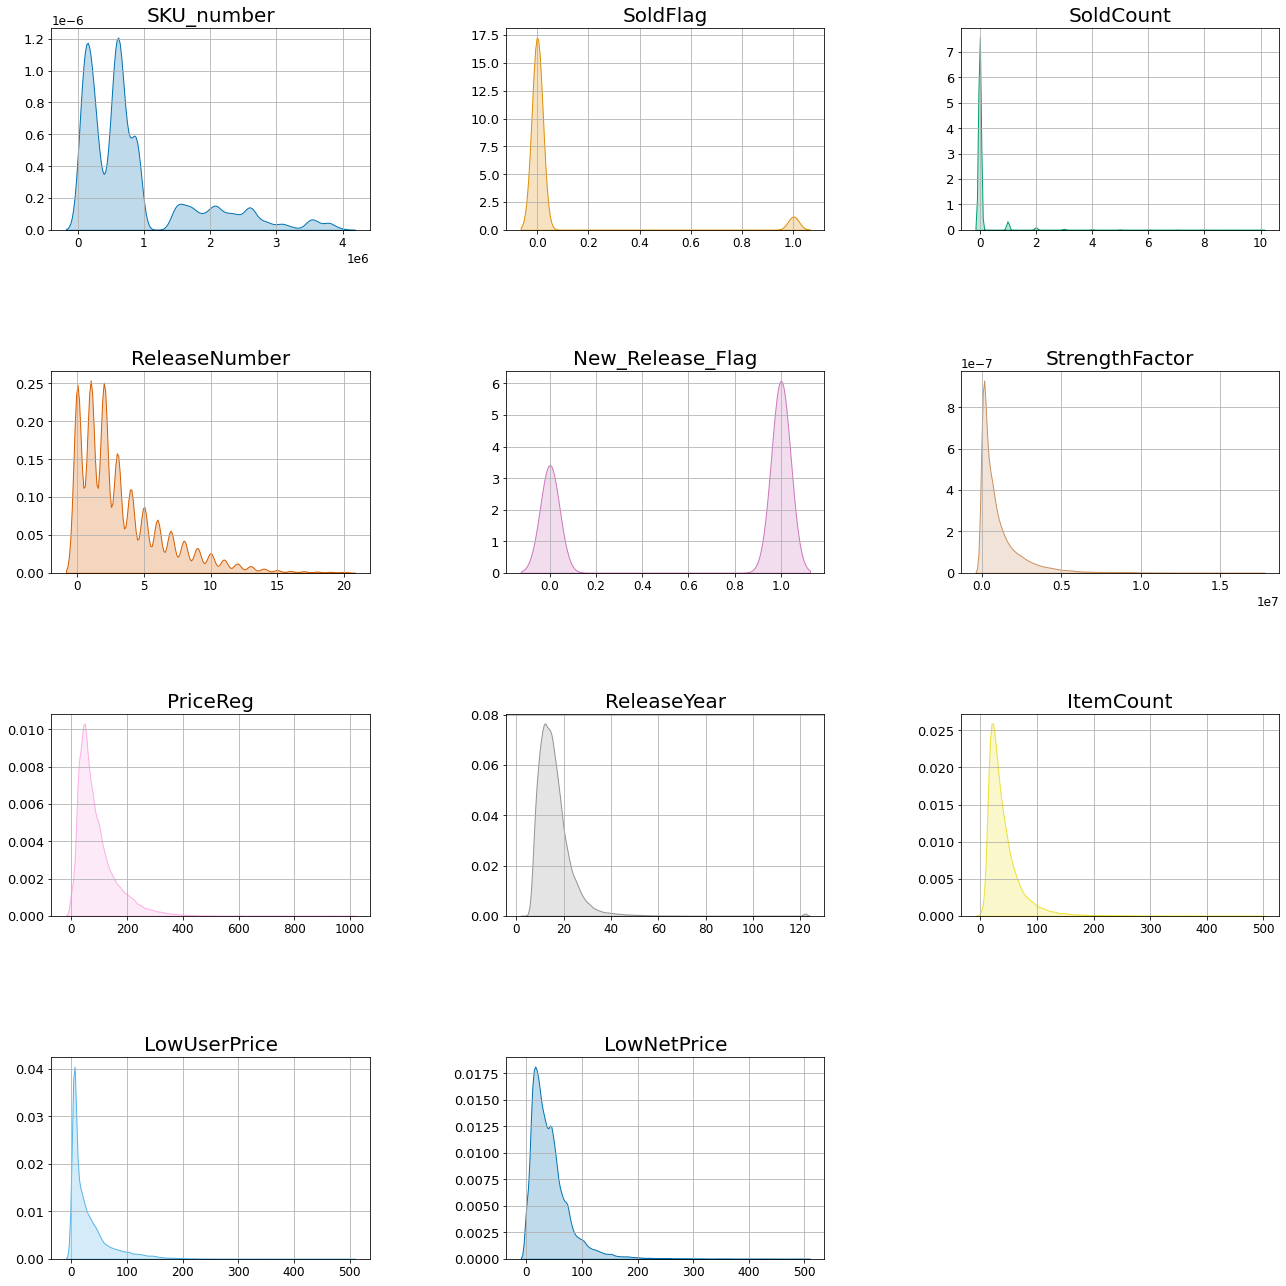

In [135]:
fig, ax = plt.subplots(figsize =(20, 20))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12

colors = sns.color_palette("colorblind", n_colors = 12).as_hex()

for i in (enumerate(numeric)):
    plt.subplot(4, 3, i[0]+1)
    sns.kdeplot(x = i[1], data = data, color = colors[i[0]], fill=True)
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    # plt.box(False)
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=7.0)
    plt.grid(b=None)

In [136]:
data.nunique()

File_Type                2
SKU_number          132158
SoldFlag                 2
SoldCount               11
MarketingType            2
ReleaseNumber           21
New_Release_Flag         2
StrengthFactor      195534
PriceReg             11500
ReleaseYear             84
ItemCount              423
LowUserPrice         12022
LowNetPrice          15119
dtype: int64

In [137]:
feature_m2 = []
feature_l2 = []

for i in data.columns:
  if data[i].nunique() > 2:
    feature_m2.append(i)
  else:
    feature_l2.append(i)

In [138]:
feature_l2

['File_Type', 'SoldFlag', 'MarketingType', 'New_Release_Flag']

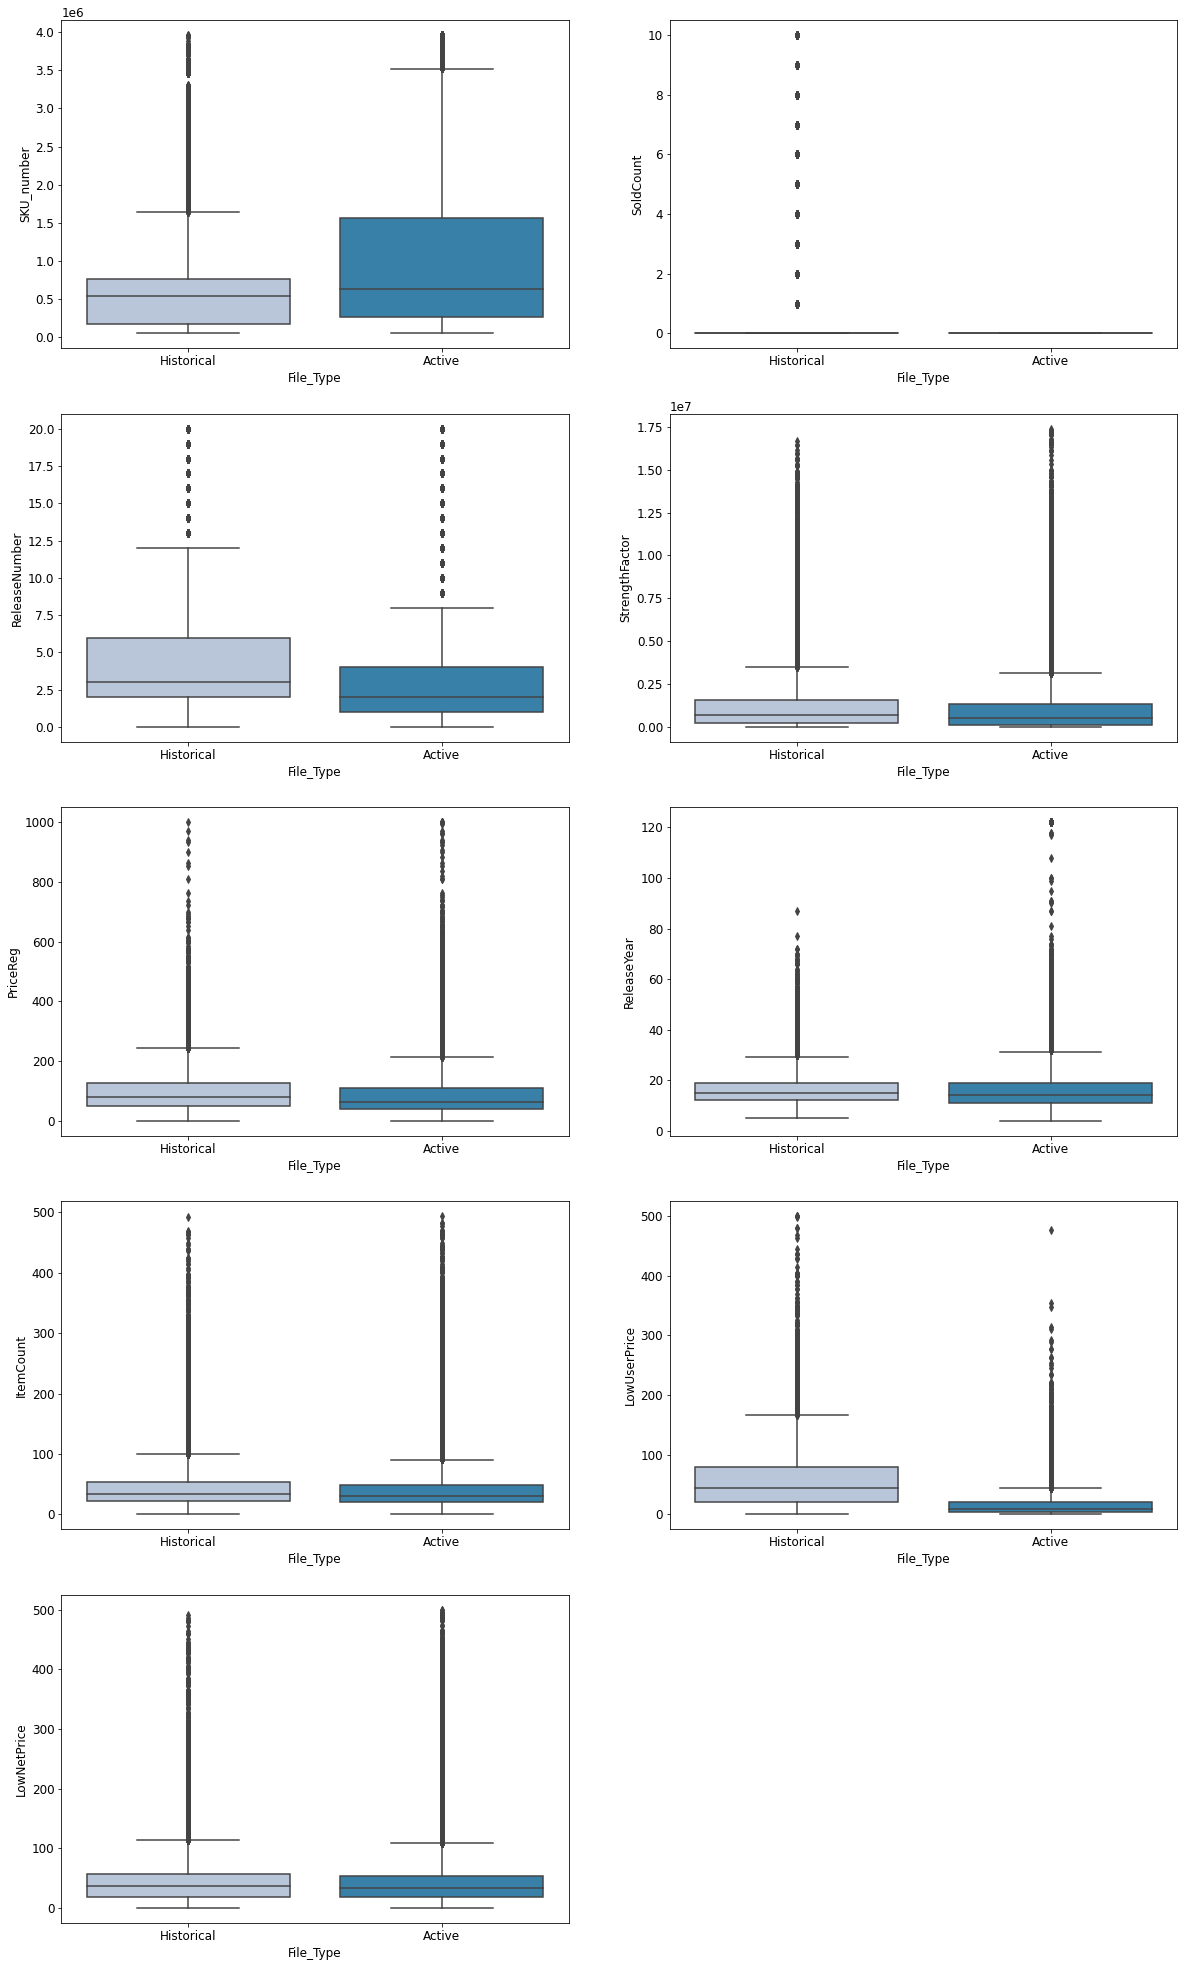

In [139]:
plt.figure(figsize=(20, 35))
a = 1
for i in feature_m2:
  if data[i].nunique() > 10:
    plt.subplot(5,2,a)
    sns.boxplot(data = data, x = 'File_Type', y = i, palette="PuBu")
    a = a+1

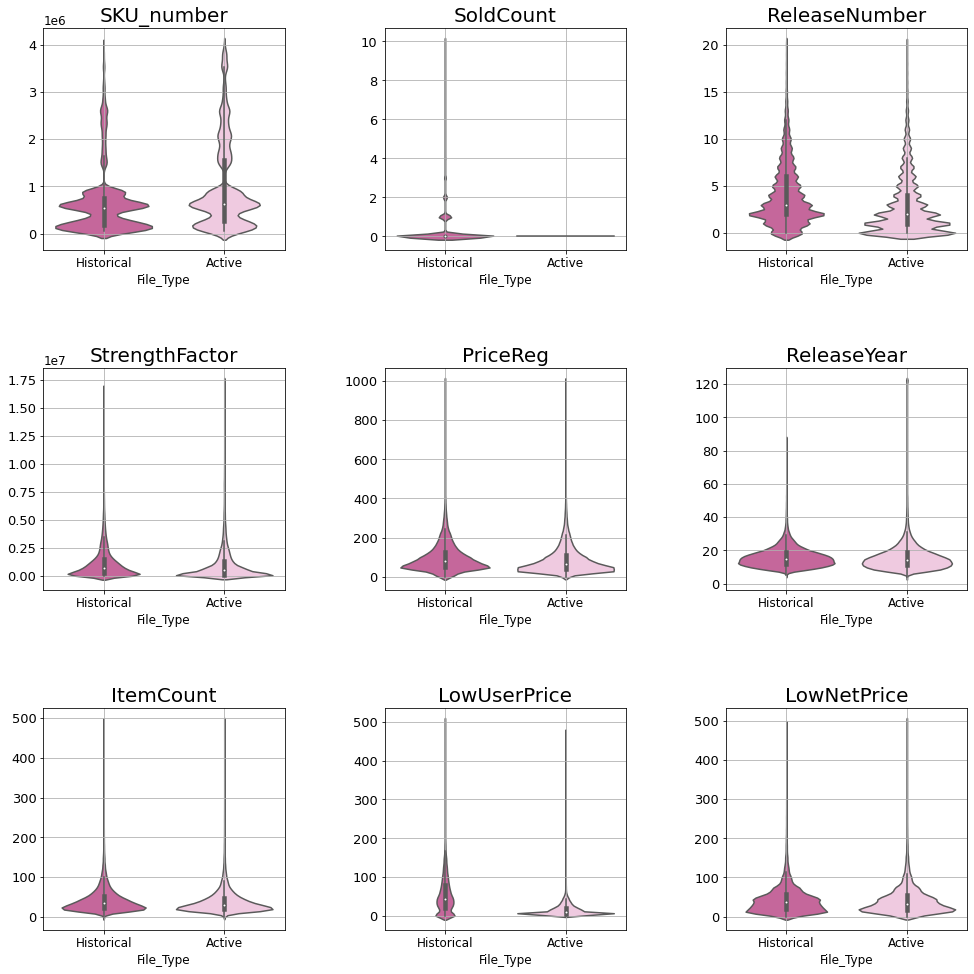

In [140]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='File_Type', y=i[1], palette = colors, data=data)
    plt.xlabel('File_Type')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

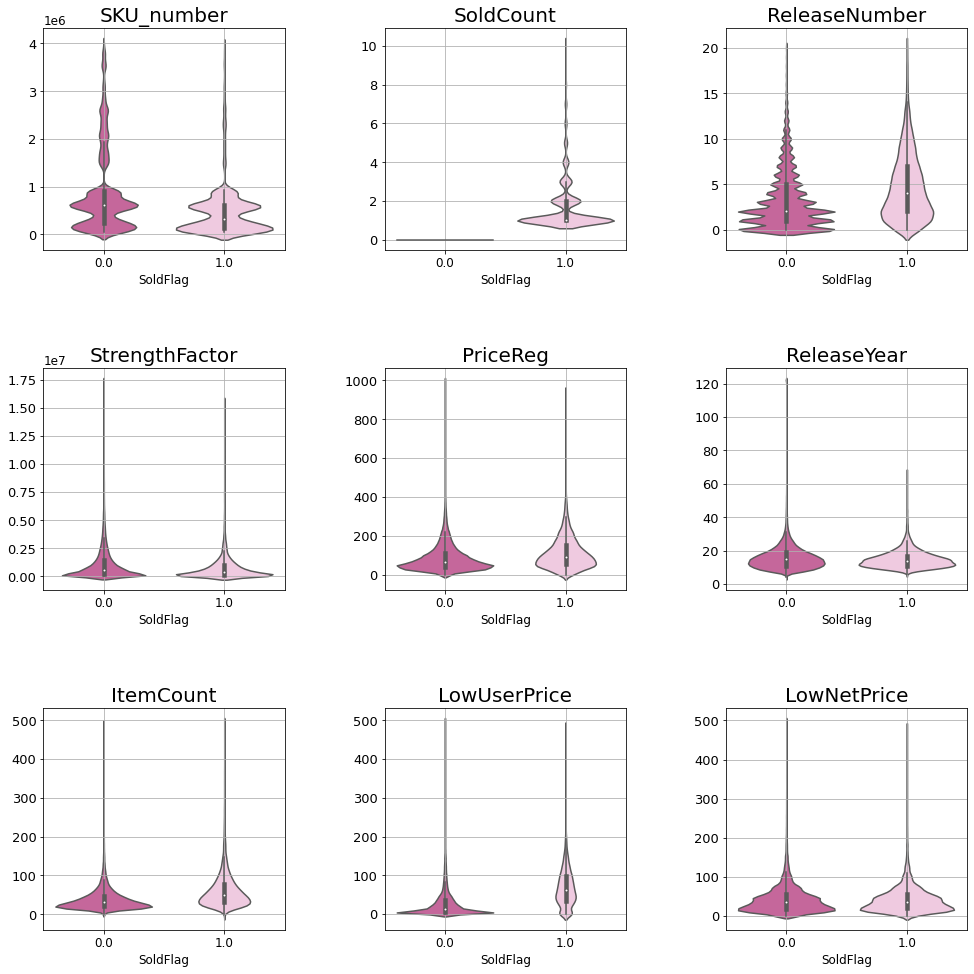

In [141]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='SoldFlag', y=i[1], palette = colors, data=data)
    plt.xlabel('SoldFlag')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

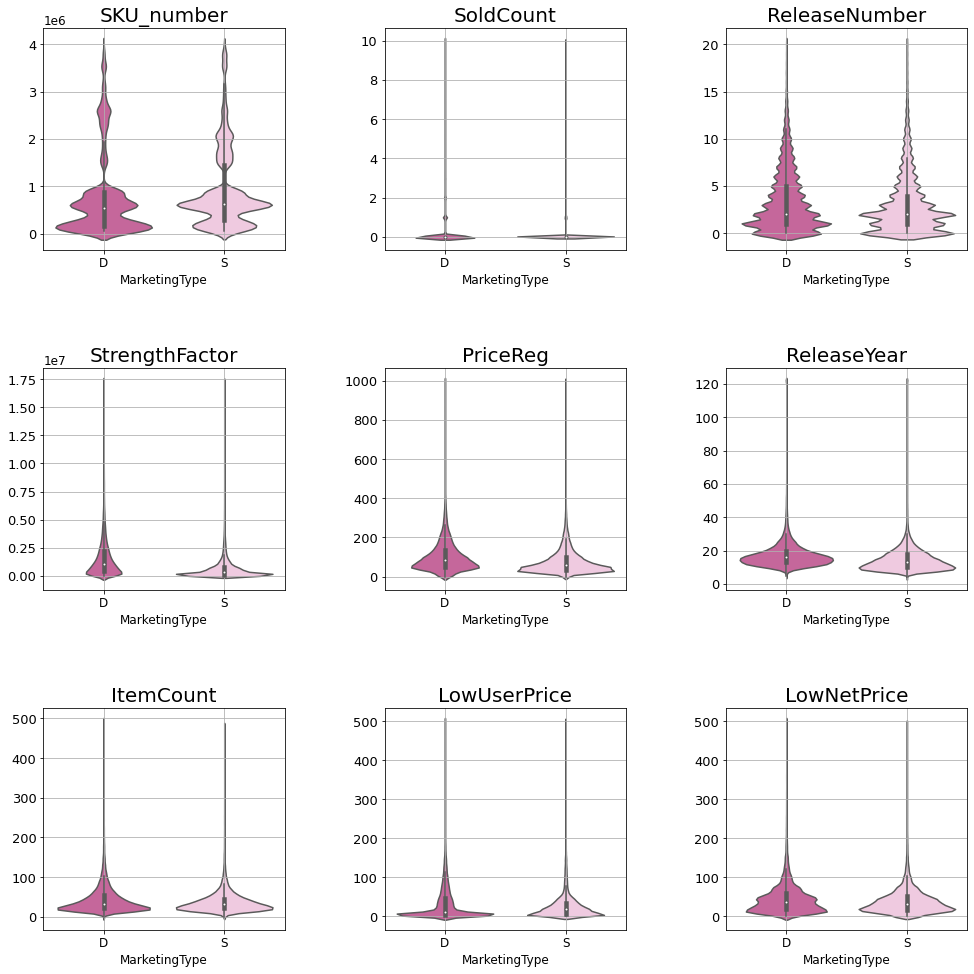

In [142]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='MarketingType', y=i[1], palette = colors, data=data)
    plt.xlabel('MarketingType')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

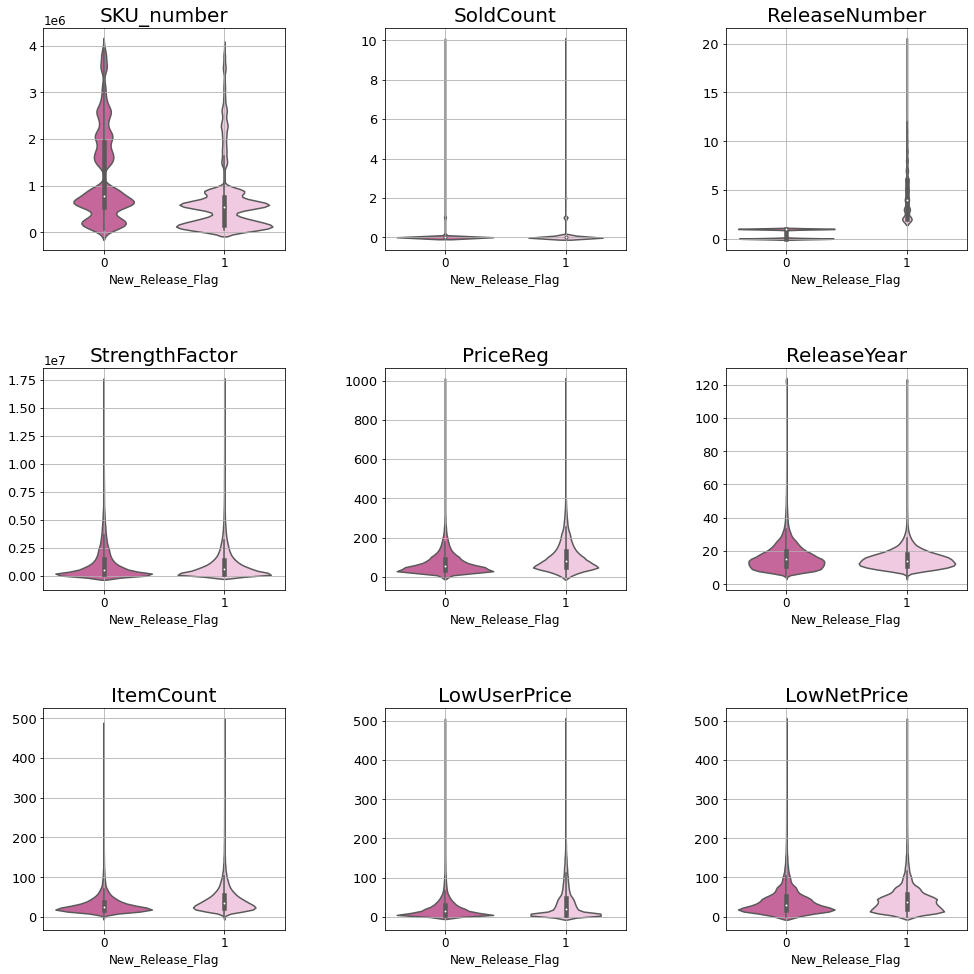

In [143]:
fig, ax = plt.subplots(figsize =(15, 15))
fig.patch.set_facecolor('white')
mpl.rcParams['font.family'] = 'DejaVu Sans'
mpl.rcParams['font.size'] = 12
colors = sns.color_palette("PiYG", n_colors = 5).as_hex()

for i in (enumerate(feature_m2)):
    plt.subplot(3, 3, i[0]+1)
    sns.violinplot(x='New_Release_Flag', y=i[1], palette = colors, data=data)
    plt.xlabel('New_Release_Flag')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(b=None)

In [144]:
data['File_Type'] = data['File_Type'].replace('Historical', 0)
data['File_Type'] = data['File_Type'].replace('Active', 1)
data['MarketingType'] = data['MarketingType'].replace('D', 0)
data['MarketingType'] = data['MarketingType'].replace('S', 1)

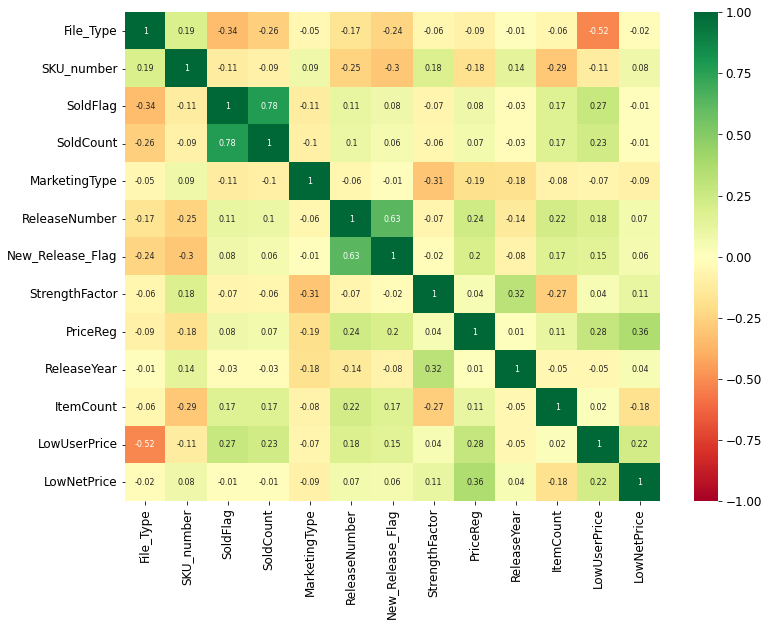

In [145]:
plt.figure(figsize=(12,9))
correlations = data.corr()
sns.heatmap(round(correlations,2), cmap='RdYlGn', annot=True, 
            annot_kws={"size": 8}, vmin=-1, vmax=1);

# **PCA**

In [146]:
iris_lm=ols('PriceReg ~  File_Type + SKU_number + SoldFlag + SoldCount + MarketingType + ReleaseNumber + New_Release_Flag + StrengthFactor + ReleaseYear + ItemCount + LowUserPrice + LowNetPrice', data=data).fit() 
a = sm.stats.anova_lm(iris_lm, typ=2)

In [199]:
a = a.sort_values(by='PR(>F)')
b = a.head(8)
b

,sum_sq,df,F,PR(>F)
SKU_number,1.316407e+07,1.0,3458.561314,0.000000e+00
MarketingType,9.838662e+06,1.0,2584.885642,0.000000e+00
ReleaseNumber,7.270851e+06,1.0,1910.251421,0.000000e+00
ItemCount,6.863386e+06,1.0,1803.199338,0.000000e+00
LowUserPrice,2.642135e+07,1.0,6941.610123,0.000000e+00
LowNetPrice,9.330888e+07,1.0,24514.795492,0.000000e+00
File_Type,3.399841e+06,1.0,893.231094,7.993828e-196
New_Release_Flag,9.526101e+05,1.0,250.276735,2.448399e-56


# **BUILDING THE MODEL**

## **Splitting the data**

In [200]:
features = b.index

In [201]:
y = np.array(data['PriceReg']).T

In [202]:
X = np.array(pd.DataFrame(data, columns = features))

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state=15)

## **Linear Regression**

In [204]:
LR = LinearRegression(normalize = True)
LR.fit(X_train,y_train)
predictions = LR.predict(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:145: FutureWarning:

'normalize' was deprecated in version 1.0 and will be removed in 1.2.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LinearRegression())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)





In [210]:
mean_squared_error(y_test, predictions)

3761.0115329922432

In [206]:
r2_score(y_test, predictions)

0.26502521469846374

In [207]:
LR.singular_

array([1.49324827, 1.19074973, 1.0504461 , 1.01954864, 0.85291374,
       0.83454191, 0.66508256, 0.58579125])

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning:

All-NaN slice encountered

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



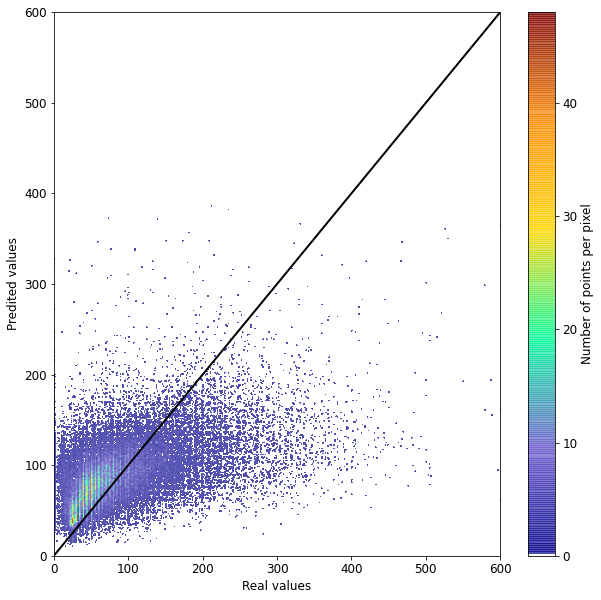

In [208]:
white_viridis = LinearSegmentedColormap.from_list('white_viridis', [
    (0, '#ffffff'),
    (1e-20, 'darkblue'),
    (0.2, 'slateblue'),
    (0.4, 'mediumspringgreen'),
    (0.6, 'gold'),
    (0.8, 'darkorange'),
    (1, 'maroon'),
], N=256)

def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap=white_viridis, alpha=0.7)
    fig.colorbar(density, label='Number of points per pixel')
fig = plt.figure(figsize=(10, 10))
using_mpl_scatter_density(fig, y_test, predictions)
fig1 = plt.subplot(1, 1, 1)
fig1.set_xlim([0, 600])
fig1.set_ylim([0, 600])
xpoints = ypoints = plt.xlim()
fig1.plot(xpoints, ypoints, linestyle='-', color='k', lw=2, scalex=False, scaley=False)
fig1.set_xlabel('Real values')
fig1.set_ylabel('Predited values')
plt.show()

## **Ridge Regression**